Code to perform float clustering via hierarchical and kmeans

In [1]:
#import packages
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime
import zipfile
pd.set_option('display.max_columns', None)

## Pre-processing
Normalization of data, add seasonality, check column datatypes

In [2]:
#Read in dataframe
zf = zipfile.ZipFile("../../data/float_loc_data_new_vars.csv.zip") 
df = pd.read_csv(zf.open('float_loc_data_new_vars2.csv'))
df.head()

,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_ipar,sat_sst,sat_poc,sat_bbp_443,sat_a_678,sat_kd_490,sat_nflh,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373


In [3]:
df.columns

Index(['float', 'latitude', 'longitude', 'cycleNumber', 'date', 'PRES', 'PSAL',
       'TEMP', 'BBP700', 'CHLA', 'short_date', 'sat_chl', 'sat_ipar',
       'sat_sst', 'sat_poc', 'sat_bbp_443', 'sat_a_678', 'sat_kd_490',
       'sat_nflh', 'sat_pic', 'sat_Rrs_678', 'sat_aph_443', 'sat_par',
       'sat_angstrom', 'sat_bb_678', 'sat_adg_443', 'sat_aot_869', 'sat_adg_s',
       'sat_bbp_s'],
      dtype='object')

In [4]:
# cor = df.corr()
# cor[abs(cor)>.7]

In [5]:
# Focuse on specific columns: sat_chl, sat_bb_678, sat_bbp_443, sat_sst, sat_poc, sat_par, sat_aph_443, sat_pic, lat, lon,
# date, (BBP700, CHLA -> we may not want these because they come from the float)
df = df[['float', 'latitude', 'longitude', 'cycleNumber', 'PRES', 'PSAL',
       'TEMP', 'BBP700', 'CHLA', 'short_date', 'sat_chl','sat_sst', 'sat_poc',
       'sat_bbp_443', 'sat_pic', 'sat_aph_443', 'sat_par','sat_bb_678']]
df.head()

,float,latitude,longitude,cycleNumber,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678
0,1902303,49.236,-14.742,1,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
1,1902303,49.236,-14.742,1,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
2,1902303,49.236,-14.742,1,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
3,1902303,49.236,-14.742,1,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
4,1902303,49.236,-14.742,1,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995


In [6]:
df['short_date']=pd.to_datetime(df['short_date'])

In [7]:
df['month'] = df['short_date'].apply(lambda x: x.month)

In [8]:
#Capture seasonality in the data
month_seasons_dict = {
    1: [1, 3],
    2: [1, 3],
    3: [2, 4],
    4: [2, 4],
    5: [2, 4],
    6: [3, 1],
    7: [3, 1],
    8: [3, 1],
    9: [4, 2],
    10: [4, 2],
    11: [4,2],
    12: [1, 3],
}
#Dictionary for our own understanding of the seasons mapping
seasons_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Summer',
    4: 'Fall'
}

In [9]:
def get_season(row):
    '''
    Description: Function to extract season from dataframe using the latitude and month
        Southern and Northern hemisphere have differing seasons so this function uses
        a dictionary to correctly map the season for the row of data.
    Input: row of dataframe
    Output: season of the row
    '''
    if row['latitude'] <0:
        season = month_seasons_dict.get(row['month'])[1]
    else:
        season = month_seasons_dict.get(row['month'])[0]
    return(season)

In [10]:
#Add column for seasonality
df['seasonality'] = df.apply(get_season, axis=1)

In [11]:
# Need to normalize the values across the PRES before performing transform and clustering
from sklearn.preprocessing import MinMaxScaler
cols= ['PSAL','TEMP', 'BBP700', 'CHLA', 'sat_chl','sat_sst', 'sat_poc',
       'sat_bbp_443', 'sat_pic', 'sat_aph_443', 'sat_par','sat_bb_678']
norm_cols = ['norm_'+col for col in cols]
#Transform all columns by min-max scaler, when min=max then the denominator is just max and don't subtract min
df[norm_cols] = df.groupby(['float','cycleNumber'])[cols].transform(lambda x: (x-x.min())/(x.max()-x.min()) if x.max() != x.min() \
       else (x)/(x.max()))
# MinMaxScaler().fit_transform(x))
# (x-x.min())/(x.max()-x.min()))
#remove old columns
# df = df.drop(cols, axis=1)
# lambda x: (x-x.mean())/x.std())
df.head()

,float,latitude,longitude,cycleNumber,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,seasonality,norm_PSAL,norm_TEMP,norm_BBP700,norm_CHLA,norm_sat_chl,norm_sat_sst,norm_sat_poc,norm_sat_bbp_443,norm_sat_pic,norm_sat_aph_443,norm_sat_par,norm_sat_bb_678
0,1902303,49.236,-14.742,1,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1902303,49.236,-14.742,1,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1902303,49.236,-14.742,1,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998913,0.958205,0.601242,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1902303,49.236,-14.742,1,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.958846,0.618520,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1902303,49.236,-14.742,1,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.959487,0.617711,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
# df[(df['float'] == 1902303)&(df['cycleNumber']==1)]['sat_chl'].describe()

count    523.000000
mean       0.370203
std        0.000000
min        0.370203
25%        0.370203
50%        0.370203
75%        0.370203
max        0.370203
Name: sat_chl, dtype: float64

In [12]:
#Bin the PRES values in segments of 10
# num_bins = 100
# labels = list(range(1,num_bins+1))
# bins = list(np.arange(0, 1010, 10))
# df['PRES_binned'] = pd.cut(df['PRES'],bins=bins, labels=labels)
bins = list(np.arange(0,201,10))+(list(np.arange(300,1101,100)))
labels=[]
for i in range(1,len(bins)):
    labels.append(str(i))
df['PRES_binned'] = pd.cut(df['PRES'],bins=bins, labels=labels)


In [13]:
df.head()

,float,latitude,longitude,cycleNumber,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,seasonality,norm_PSAL,norm_TEMP,norm_BBP700,norm_CHLA,norm_sat_chl,norm_sat_sst,norm_sat_poc,norm_sat_bbp_443,norm_sat_pic,norm_sat_aph_443,norm_sat_par,norm_sat_bb_678,PRES_binned
0,1902303,49.236,-14.742,1,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1902303,49.236,-14.742,1,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1902303,49.236,-14.742,1,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998913,0.958205,0.601242,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1902303,49.236,-14.742,1,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.958846,0.618520,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1902303,49.236,-14.742,1,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.959487,0.617711,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [15]:
df.to_csv('../../data/preprocessed_df.csv')
# compression_opts = dict(method='zip',
#                         archive_name='preprocessed_df.csv')  
# df.to_csv('../../data/preprocessed_df.zip', compression=compression_opts)

## Clustering

In [2]:
#Read in intermediate data to skip pre-processing time above
zf = zipfile.ZipFile("../../data/transformed_df.csv.zip") 
df = pd.read_csv(zf.open('transformed_df.csv'))
df.head()

,Unnamed: 0,float,latitude,longitude,cycleNumber,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,seasonality,norm_PSAL,norm_TEMP,norm_BBP700,norm_CHLA,norm_sat_chl,norm_sat_sst,norm_sat_poc,norm_sat_bbp_443,norm_sat_pic,norm_sat_aph_443,norm_sat_par,norm_sat_bb_678,PRES_binned
0,0,1902303,49.236,-14.742,1,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"(0, 10]"
1,1,1902303,49.236,-14.742,1,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"(0, 10]"
2,2,1902303,49.236,-14.742,1,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998913,0.958205,0.601242,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"(0, 10]"
3,3,1902303,49.236,-14.742,1,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.958846,0.618520,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"(0, 10]"
4,4,1902303,49.236,-14.742,1,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.959487,0.617711,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"(0, 10]"


In [16]:
pivoted = pd.pivot_table(data=df,columns='PRES_binned',values=['norm_CHLA','norm_BBP700'], aggfunc='mean', index=['float','cycleNumber'])
pivoted = pivoted.reset_index()
pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
pivoted = pivoted.rename(columns={'float_':'float','cycleNumber_':'cycleNumber'})
pivoted.head()

,float,cycleNumber,norm_BBP700_1,norm_BBP700_2,norm_BBP700_3,norm_BBP700_4,norm_BBP700_5,norm_BBP700_6,norm_BBP700_7,norm_BBP700_8,norm_BBP700_9,norm_BBP700_10,norm_BBP700_11,norm_BBP700_12,norm_BBP700_13,norm_BBP700_14,norm_BBP700_15,norm_BBP700_16,norm_BBP700_17,norm_BBP700_18,norm_BBP700_19,norm_BBP700_20,norm_BBP700_21,norm_BBP700_22,norm_BBP700_23,norm_BBP700_24,norm_BBP700_25,norm_BBP700_26,norm_BBP700_27,norm_BBP700_28,norm_BBP700_29,norm_CHLA_1,norm_CHLA_2,norm_CHLA_3,norm_CHLA_4,norm_CHLA_5,norm_CHLA_6,norm_CHLA_7,norm_CHLA_8,norm_CHLA_9,norm_CHLA_10,norm_CHLA_11,norm_CHLA_12,norm_CHLA_13,norm_CHLA_14,norm_CHLA_15,norm_CHLA_16,norm_CHLA_17,norm_CHLA_18,norm_CHLA_19,norm_CHLA_20,norm_CHLA_21,norm_CHLA_22,norm_CHLA_23,norm_CHLA_24,norm_CHLA_25,norm_CHLA_26,norm_CHLA_27,norm_CHLA_28,norm_CHLA_29
0,1902303,1,0.958590,0.975677,0.968304,0.947960,0.904060,0.929502,0.989180,0.920309,0.779483,0.665161,0.477296,0.395800,0.345118,0.289163,0.262325,0.220864,0.182874,0.149571,0.118132,0.098300,0.058524,0.026356,0.032922,0.023188,0.005953,0.004707,0.021234,0.023193,NaN,0.607775,0.606574,0.585943,0.576876,0.634134,0.804918,0.948389,0.703274,0.590623,0.387959,0.283998,0.207259,0.151516,0.105832,0.083531,0.078618,0.068147,0.051350,0.037797,0.026674,0.013392,0.001965,0.000932,0.000929,0.001831,0.003110,0.003800,0.003944,NaN
1,1902303,2,0.994425,0.936276,0.873217,0.877985,0.868212,0.925928,0.983635,0.918443,0.782578,0.591071,0.460189,0.342840,0.297124,0.255665,0.230725,0.208858,0.160719,0.155832,0.190902,0.149935,0.060801,0.025795,0.032430,0.019185,0.004322,0.003968,NaN,NaN,NaN,0.459589,0.442257,0.498355,0.511448,0.557241,0.870069,0.921003,0.624130,0.429952,0.289870,0.194206,0.126169,0.100635,0.083898,0.070393,0.062695,0.047164,0.044920,0.061656,0.041887,0.015751,0.003261,0.000752,0.000889,0.001102,0.002245,NaN,NaN,NaN
2,1902303,3,0.995962,0.958379,0.925792,0.879905,0.815748,0.869650,0.856361,0.777580,0.645791,0.470536,0.436806,0.393269,0.258451,0.211399,0.175152,0.143616,0.123847,0.109021,0.081352,0.081557,0.055596,0.033712,0.038139,0.019997,0.003591,0.007470,0.019390,0.031428,NaN,0.804349,0.804814,0.740132,0.712499,0.721224,0.924742,0.821413,0.641082,0.402826,0.228197,0.210515,0.210116,0.105129,0.076873,0.063298,0.048594,0.049634,0.040258,0.021130,0.018908,0.017717,0.003640,0.001101,0.001446,0.001091,0.002461,0.003242,0.003132,NaN
3,1902303,4,0.980306,0.975088,0.981627,0.997919,0.980925,0.947418,0.818796,0.653879,0.382833,0.293863,0.227696,0.208961,0.159440,0.131152,0.119786,0.114274,0.099176,0.086014,0.088810,0.088035,0.083891,0.028160,0.029827,0.015065,0.002952,0.005619,0.011048,0.004849,NaN,0.837543,0.824118,0.832718,0.885432,0.828246,0.801971,0.515847,0.215865,0.084658,0.051803,0.036271,0.025845,0.021226,0.015628,0.013944,0.013343,0.008993,0.007567,0.005520,0.006544,0.004656,0.000941,0.000862,0.000742,0.000632,0.001747,0.002079,0.002336,NaN
4,1902303,5,0.972730,0.995867,0.972389,0.965353,0.968112,0.992332,0.889309,0.579428,0.395167,0.319443,0.203392,0.170447,0.146445,0.170169,0.177889,0.159955,0.141758,0.122985,0.116965,0.117292,0.096235,0.037748,0.036839,0.028428,0.020700,0.013834,0.018775,0.003963,NaN,0.900671,0.927776,0.935219,0.928941,0.933363,0.912894,0.847936,0.216904,0.076113,0.054412,0.034457,0.023285,0.022184,0.029160,0.027725,0.027445,0.022303,0.018749,0.012912,0.010676,0.005662,0.001167,0.000938,0.001230,0.001929,0.002625,0.003121,0.003313,NaN


In [17]:
pivoted.shape

(58453, 60)

In [18]:
df_info = df[['float','cycleNumber','seasonality','latitude','longitude']]
df_info = df_info.drop_duplicates()
df_info.shape

(58819, 5)

In [19]:
pivoted = pivoted.merge(df_info, how='left',on=['float','cycleNumber'])
pivoted.head()

,float,cycleNumber,norm_BBP700_1,norm_BBP700_2,norm_BBP700_3,norm_BBP700_4,norm_BBP700_5,norm_BBP700_6,norm_BBP700_7,norm_BBP700_8,norm_BBP700_9,norm_BBP700_10,norm_BBP700_11,norm_BBP700_12,norm_BBP700_13,norm_BBP700_14,norm_BBP700_15,norm_BBP700_16,norm_BBP700_17,norm_BBP700_18,norm_BBP700_19,norm_BBP700_20,norm_BBP700_21,norm_BBP700_22,norm_BBP700_23,norm_BBP700_24,norm_BBP700_25,norm_BBP700_26,norm_BBP700_27,norm_BBP700_28,norm_BBP700_29,norm_CHLA_1,norm_CHLA_2,norm_CHLA_3,norm_CHLA_4,norm_CHLA_5,norm_CHLA_6,norm_CHLA_7,norm_CHLA_8,norm_CHLA_9,norm_CHLA_10,norm_CHLA_11,norm_CHLA_12,norm_CHLA_13,norm_CHLA_14,norm_CHLA_15,norm_CHLA_16,norm_CHLA_17,norm_CHLA_18,norm_CHLA_19,norm_CHLA_20,norm_CHLA_21,norm_CHLA_22,norm_CHLA_23,norm_CHLA_24,norm_CHLA_25,norm_CHLA_26,norm_CHLA_27,norm_CHLA_28,norm_CHLA_29,seasonality,latitude,longitude
0,1902303,1,0.958590,0.975677,0.968304,0.947960,0.904060,0.929502,0.989180,0.920309,0.779483,0.665161,0.477296,0.395800,0.345118,0.289163,0.262325,0.220864,0.182874,0.149571,0.118132,0.098300,0.058524,0.026356,0.032922,0.023188,0.005953,0.004707,0.021234,0.023193,NaN,0.607775,0.606574,0.585943,0.576876,0.634134,0.804918,0.948389,0.703274,0.590623,0.387959,0.283998,0.207259,0.151516,0.105832,0.083531,0.078618,0.068147,0.051350,0.037797,0.026674,0.013392,0.001965,0.000932,0.000929,0.001831,0.003110,0.003800,0.003944,NaN,2,49.236,-14.742
1,1902303,2,0.994425,0.936276,0.873217,0.877985,0.868212,0.925928,0.983635,0.918443,0.782578,0.591071,0.460189,0.342840,0.297124,0.255665,0.230725,0.208858,0.160719,0.155832,0.190902,0.149935,0.060801,0.025795,0.032430,0.019185,0.004322,0.003968,NaN,NaN,NaN,0.459589,0.442257,0.498355,0.511448,0.557241,0.870069,0.921003,0.624130,0.429952,0.289870,0.194206,0.126169,0.100635,0.083898,0.070393,0.062695,0.047164,0.044920,0.061656,0.041887,0.015751,0.003261,0.000752,0.000889,0.001102,0.002245,NaN,NaN,NaN,2,49.096,-14.617
2,1902303,3,0.995962,0.958379,0.925792,0.879905,0.815748,0.869650,0.856361,0.777580,0.645791,0.470536,0.436806,0.393269,0.258451,0.211399,0.175152,0.143616,0.123847,0.109021,0.081352,0.081557,0.055596,0.033712,0.038139,0.019997,0.003591,0.007470,0.019390,0.031428,NaN,0.804349,0.804814,0.740132,0.712499,0.721224,0.924742,0.821413,0.641082,0.402826,0.228197,0.210515,0.210116,0.105129,0.076873,0.063298,0.048594,0.049634,0.040258,0.021130,0.018908,0.017717,0.003640,0.001101,0.001446,0.001091,0.002461,0.003242,0.003132,NaN,2,48.914,-14.606
3,1902303,4,0.980306,0.975088,0.981627,0.997919,0.980925,0.947418,0.818796,0.653879,0.382833,0.293863,0.227696,0.208961,0.159440,0.131152,0.119786,0.114274,0.099176,0.086014,0.088810,0.088035,0.083891,0.028160,0.029827,0.015065,0.002952,0.005619,0.011048,0.004849,NaN,0.837543,0.824118,0.832718,0.885432,0.828246,0.801971,0.515847,0.215865,0.084658,0.051803,0.036271,0.025845,0.021226,0.015628,0.013944,0.013343,0.008993,0.007567,0.005520,0.006544,0.004656,0.000941,0.000862,0.000742,0.000632,0.001747,0.002079,0.002336,NaN,2,48.794,-14.689
4,1902303,5,0.972730,0.995867,0.972389,0.965353,0.968112,0.992332,0.889309,0.579428,0.395167,0.319443,0.203392,0.170447,0.146445,0.170169,0.177889,0.159955,0.141758,0.122985,0.116965,0.117292,0.096235,0.037748,0.036839,0.028428,0.020700,0.013834,0.018775,0.003963,NaN,0.900671,0.927776,0.935219,0.928941,0.933363,0.912894,0.847936,0.216904,0.076113,0.054412,0.034457,0.023285,0.022184,0.029160,0.027725,0.027445,0.022303,0.018749,0.012912,0.010676,0.005662,0.001167,0.000938,0.001230,0.001929,0.002625,0.003121,0.003313,NaN,2,48.719,-14.795


In [20]:
pivoted_clustering = pivoted.drop(['float','cycleNumber','latitude','longitude'],axis=1)

In [21]:
drop_cols = [col for col in pivoted_clustering.columns if '_29' in col]
pivoted_clustering=pivoted_clustering.drop(drop_cols, axis=1)

In [22]:
pivoted_clustering= pivoted_clustering.fillna(0)

In [23]:
from sklearn.metrics import silhouette_score

In [24]:
silhouette_avgs = []
for i in range(2,8):
    clustering_kmeans = KMeans(n_clusters=i)
    clusters = clustering_kmeans.fit_predict(pivoted_clustering)
    silhouette_avg = silhouette_score(pivoted_clustering, clusters)
    silhouette_avgs.append(silhouette_avg)

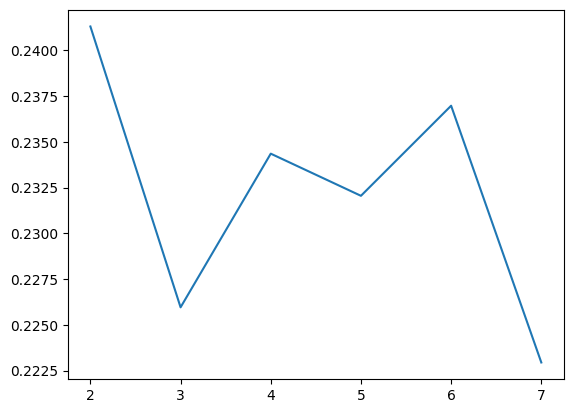

In [25]:
plt.plot(np.arange(2,len(silhouette_avgs)+2,1),silhouette_avgs)

In [31]:
#Choose k=6 bc max silhouette
clustering_kmeans = KMeans(n_clusters=6)
clusters = clustering_kmeans.fit_predict(pivoted_clustering)
pivoted['cluster'] = clusters

In [36]:
pivoted['cluster'].value_counts()

1    12496
5    10964
2     9549
4     9348
3     8436
0     7660
Name: cluster, dtype: int64

In [52]:
cluster_df = df[['float','latitude','longitude','cycleNumber','PRES','PRES_binned','norm_BBP700','norm_CHLA']].merge(pivoted[['float','cycleNumber','cluster']], how='left',on=['float','cycleNumber'])
cluster_df.head()

,float,latitude,longitude,cycleNumber,PRES,PRES_binned,norm_BBP700,norm_CHLA,cluster
0,1902303,49.236,-14.742,1,3,1,0.958205,0.600702,1.0
1,1902303,49.236,-14.742,1,4,1,0.958205,0.600702,1.0
2,1902303,49.236,-14.742,1,6,1,0.958205,0.601242,1.0
3,1902303,49.236,-14.742,1,8,1,0.958846,0.618520,1.0
4,1902303,49.236,-14.742,1,10,1,0.959487,0.617711,1.0


In [56]:
test = cluster_df[cluster_df['cluster']==1]
test_float_cycle = test[['float','cycleNumber']].drop_duplicates()
test2 = cluster_df[cluster_df['cluster']==2]
test_float_cycle2 = test2[['float','cycleNumber']].drop_duplicates()

In [57]:
import random
randomlist = random.sample(range(0, len(test_float_cycle)), 10)
randomlist2 = random.sample(range(0, len(test_float_cycle2)), 10)

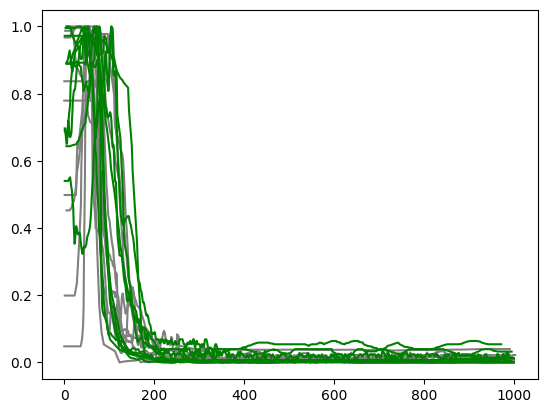

In [59]:
for i in randomlist:
    temp = test[(test['float'] == test_float_cycle.iloc[i]['float'])&(test['cycleNumber'] == test_float_cycle.iloc[i]['cycleNumber'])]
    plt.plot(temp['PRES'],temp['norm_CHLA'], color='gray')
for i in randomlist2:
    temp = test2[(test2['float'] == test_float_cycle2.iloc[i]['float'])&(test2['cycleNumber'] == test_float_cycle2.iloc[i]['cycleNumber'])]
    plt.plot(temp['PRES'],temp['norm_CHLA'], color='green')

In [32]:
def plot_on_map(df, source, features=None, data_type=None, figsize=(10,4), subtitle=None):
    '''
    function to plot latitude and longitude of (float or satellite) data over the world map, colored by zero or more features
    
    arguments
    ---------
    df (pandas df):
        dataframe, already filtered as desired
    source (str):
            satellite, float, or a matchup; used in the plot titles
    features (str or list-like or None):
              string of a single feature, or list of strings of features corresponding to column names of df;
              there will be a different plot for every feature;
              if features is None, just latitude and longitude will be plotted with no coloring by feature;
              list of features may include None
    data_type (str or list-like or None):
               single or list containing 'continuous', 'discrete' or 'categorical', or None to determine use of colorbar, legend, or no color respectively ;
               if a single value, then it is assumed to be applied to all features;
               if a list, then it it must have the same length as the list of features
    figsize (tuple):
             figsize argument passed to plt.figure()
    subtitle (str or None):
              optional additional line to add to the title; a single string that will be applied to all plots
    '''
    
    # argument modifications
    if type(features) == str:
        features = [features]
        
    if features is None:
        features = [None]
        
    if data_type == 'discrete':
        data_type = 'categorical'
    
    if type(data_type) == list:
        data_type = ['categorical' if t=='discrete' else t for t in data_type]
        
    if type(data_type) == list and len(features) != len(data_type):
        print('Error — len(features) and len(data_type) should be equal')
        return
    
    if subtitle is not None and subtitle.strip() == '':
        subtitle = None
        
    # obtain map
    land = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    
    for f in features:
        
        # plot the base map
        land.plot(color='lightgray', figsize=figsize)
        
        # scatter plot with no color if feature is None
        if f is None:
            plt.scatter(df['longitude'], df['latitude'], s=3, alpha=0.7)
            if subtitle is None:
                plt.title(f'Latitude vs. Longitude for {source.title()} Data', fontsize='x-large')
            else:
                plt.title(f'Latitude vs. Longitude for {source.title()} Data\n({subtitle})', fontsize='x-large')
            
        else:
            f_df = df[df[f].notna()].reset_index(drop=True)

            # scatter plot, colored by continuous feature
            if data_type == 'continuous' or (type(data_type) == list and data_type[features.index(f)] == 'continuous'):
                plt.scatter(f_df['longitude'], f_df['latitude'], c=f_df[f], cmap='plasma', s=3, alpha=0.7)
                plt.colorbar(label=f)

            # scatter plot, colored by categorical feature
            elif data_type == 'categorical' or (type(data_type) == list and data_type[features.index(f)] == 'categorical'):
                colors =  [list(np.unique(f_df[f])).index(v) for v in f_df[f]]
                color_indices = np.unique(colors, return_index=True)[1]
                labels = [f_df.loc[i,f] for i in sorted(color_indices)]
                scatter = plt.scatter(f_df['longitude'], f_df['latitude'], c=colors, cmap='plasma', s=3, alpha=0.7)
                plt.legend(handles=scatter.legend_elements()[0], labels=labels, title=f, loc='upper left', bbox_to_anchor=(1,1))

            if subtitle is None:
                plt.title(f'{source.title()} Data Latitude vs. Longitude\nColored by {f}', fontsize='x-large')
            else:
                plt.title(f'{source.title()} Data Latitude vs. Longitude\nColored by {f}\n({subtitle})', fontsize='x-large')
            
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        
        # display plot
        plt.show()

In [33]:
seasons_dict

{1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}

In [34]:
summer = pivoted[pivoted['seasonality'] ==3]
winter = pivoted[pivoted['seasonality'] ==1]
fall = pivoted[pivoted['seasonality'] ==4]
spring = pivoted[pivoted['seasonality'] ==2]


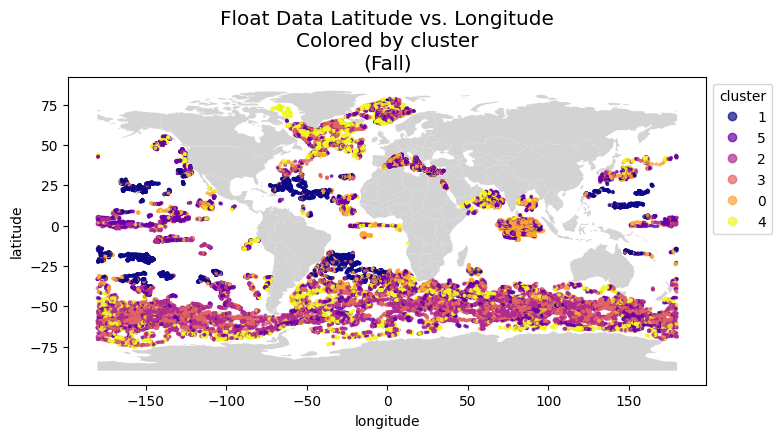

In [35]:
import geopandas as gpd
plot_on_map(
    df=pivoted,
    features='cluster',
    data_type='categorical',
    source='float',
    subtitle='Fall'
)

# Hierarchical clustering

In [31]:
clustering_hierarchical = AgglomerativeClustering(n_clusters=5)
clusters_hierarchical = clustering_hierarchical.fit_predict(pivoted_clustering)
silhouette_avg_hierarchical = silhouette_score(pivoted_clustering, clusters_hierarchical)
silhouette_avg_hierarchical
#Stopped after 239m